In [1]:
from pathlib import Path
import cantera as ct
import matplotlib.pyplot as plt


In [2]:
p = ct.one_atm  # pressure
tin_f = 300.0  # fuel inlet temperature
tin_o = 300.0  # oxidizer inlet temperature


In [3]:
gas = ct.Solution('Jerzembeck.yaml')
gas.TP = gas.T, p
density = gas.density
print(f"Density : {density}")
mdot_o = 1.8375  # kg/m^2/s
mdot_f = 3.5604
   # kg/m^2/s
comp_o = 'O2:0.21, N2:0.78, AR:0.01'
comp_f = 'IXC8H18:1'
width = 0.02
loglevel = 1


Density : 1.1379843694698795


In [4]:
f = ct.CounterflowDiffusionFlame(gas, width=width)
f.fuel_inlet.mdot = mdot_f
f.fuel_inlet.X = comp_f
f.fuel_inlet.T = tin_f

In [5]:
f.oxidizer_inlet.mdot = mdot_o
f.oxidizer_inlet.X = comp_o
f.oxidizer_inlet.T = tin_o

In [6]:
f.boundary_emissivities = 0.0, 0.0
# Turn radiation off
f.radiation_enabled = False

In [7]:
f.set_refine_criteria(ratio=4, slope=0.2, curve=0.1, prune=0.04)
f.solve(loglevel, auto=True)
f.show()
if "native" in ct.hdf_support():
    output = Path() / "diffusion_flame.h5"
else:
    output = Path() / "diffusion_flame.yaml"
output.unlink(missing_ok=True)

f.save(output)
f.save('diffusion_flame.csv', basis="mole", overwrite=True)

f.show_stats(0)




************ Solving on 6 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...

    failure. 
Take 10 timesteps     4.449e-07      6.104
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      1.14e-05      6.243
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001948      5.174
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001644      5.222
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005548      5.107
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.004213      3.821
Attempt Newton solution of steady-state problem...    success.

Problem solved on [6] point grid(s).

..............................................................................
grid refinement disabled.

******** Initial solve failed; Retrying with energy equation disabled ********

..............................................................................
Attempt Newton solution of steady-state p

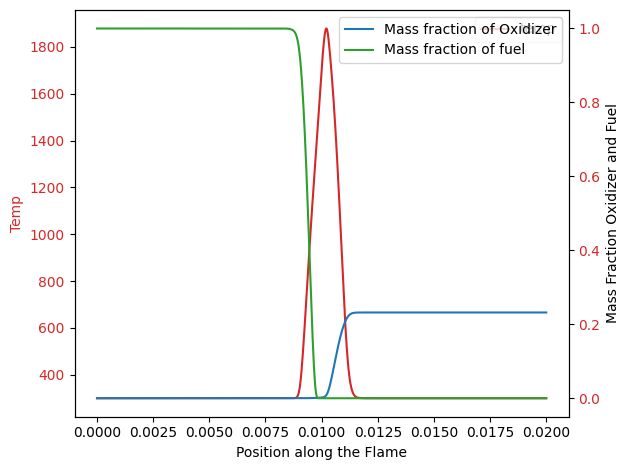

In [24]:
fuel_index = gas.species_index('IXC8H18')
oxidizer_index = gas.species_index('O2') 
mass_fuel = f.Y[fuel_index]
mass_oxidizer = f.Y[oxidizer_index]
with open('mass_fractions.csv', 'w') as file:
    file.write('Position, Mass Fraction Fuel, Mass Fraction Oxidizer\n')
    for i, (x, y_fuel, y_oxidizer) in enumerate(zip(f.flame.grid, mass_fuel, mass_oxidizer)):
        file.write(f'{x:.6f}, {y_fuel:.6f}, {y_oxidizer:.6f}\n')
color = 'tab:red'
fig, ax1 = plt.subplots()
ax1.plot(f.flame.grid, f.T, color=color, label='temp')
ax1.set_xlabel('Position along the Flame')
ax1.set_ylabel('Temp', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color1 = 'tab:blue'
color2 = 'tab:green'
ax2.plot(f.flame.grid, mass_oxidizer, color=color1,label= "Mass fraction of Oxidizer")
ax2.plot(f.flame.grid,mass_fuel,color=color2,label= 'Mass fraction of fuel')
ax2.legend()
ax1.legend()
ax2.set_ylabel('Mass Fraction Oxidizer and Fuel')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()



(0.0, 0.02)

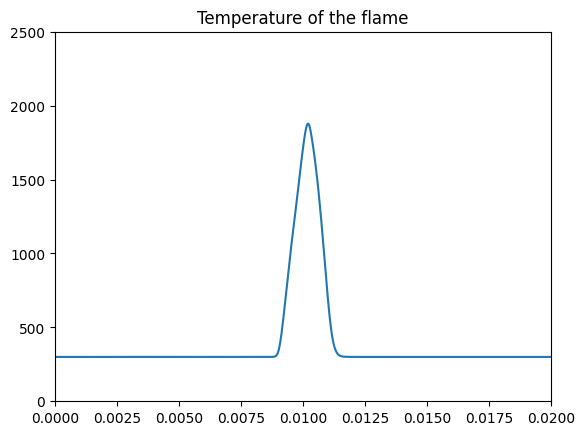

In [15]:
figTemperatureModifiedFlame = plt.figure()
plt.plot(f.flame.grid, f.T, label='Temperature without radiation')
plt.title('Temperature of the flame')
plt.ylim(0,2500)
plt.xlim(0.000, 0.020)
#f.radiation_enabled = True
#f.solve(loglevel=1, refine_grid=False)
#f.show()
#plt.plot(f.flame.grid, f.T, label='Temperature with radiation')
#plt.legend()
#plt.legend(loc=2)
#plt.savefig('./diffusion_flame.pdf')


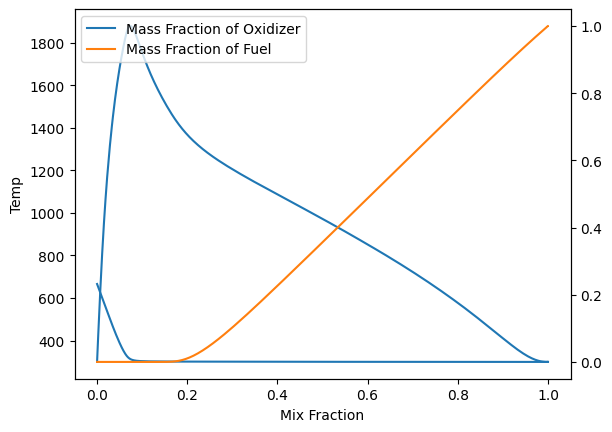

In [25]:
#Mix = f.mixture_fraction('C')
f.mixture_fraction('Bilger')
fig, ax1 = plt.subplots()

ax1.plot(f.mixture_fraction('Bilger'),f.T)
ax1.set_xlabel('Mix Fraction')
ax1.set_ylabel('Temp')

ax2 = ax1.twinx()
ax2.plot(f.mixture_fraction('Bilger'),mass_oxidizer,label= 'Mass Fraction of Oxidizer')
ax2.plot(f.mixture_fraction('Bilger'),mass_fuel,label = 'Mass Fraction of Fuel')
ax2.legend()
#fig.tight_layout()
plt.show()

In [44]:
A = ct.Quantity(gas)
A.TPX = 300, ct.one_atm, 'O2:0.21, N2:0.78'
A.moles = 12.5

B= ct.Quantity(gas)
B.TPX = 300,ct.one_atm,'IXC8H18:1'
B.moles= 1

M= A+B 
M.equilibrate('HP')
print(M.T)

1071.9735991015352
